In [42]:
library(tableone)
library(ipw)
library(sandwich)
library(survey)

In [43]:
#load dataset
load(url("http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.sav"))

In [44]:
ARF <- as.numeric(rhc$cat1 == 'ARF')
CHF<- as.numeric(rhc$cat1=='CHF')
Cirr<- as.numeric(rhc$cat1 == 'Cirrhosis')
colcan <- as.numeric(rhc$cat1 == 'Colon Cancer')
Coma<- as.numeric(rhc$cat1 == 'Coma')
COPD <- as.numeric(rhc$cat1 == 'COPD')
lungcan <- as.numeric(rhc$cat1 == 'Lung Cancer')
MOSF <- as.numeric(rhc$cat1 == 'MOSF w/Malignancy')
sepsis<- as.numeric(rhc$cat1 == 'MOSF w/Sepsis')
female <- as.numeric(rhc$sex == 'Female')
died <- as.numeric(rhc$death == 'Yes')
age <- rhc$age
treatment <- as.numeric(rhc$swang1 == 'RHC')
meanbp1 <- rhc$meanbp1
aps <- rhc$aps1

mydata<- cbind(ARF, CHF, Cirr, colcan, Coma, lungcan, MOSF, sepsis, age, female, meanbp1, aps, treatment, died)
mydata <- data.frame(mydata)

In [45]:
# propensity score model
psmodel <- glm(treatment~ ARF+ CHF+ Cirr+ colcan + Coma+ lungcan+ MOSF + sepsis + age + female + meanbp1 + aps,
               family = binomial(), data = mydata)

# value of propensity score for each subject
ps<- predict(psmodel, type = 'response')

In [46]:
# create weights and check balance

weight <- ifelse(treatment == 1, 1/ps, 1/(1-ps))

In [47]:
#apply weight to data
weighteddata <- svydesign(ids= ~1, data= mydata, weights = ~weight)

In [48]:
#weighted table 1
xvars <- c('ARF', 'CHF', 'Cirr', 'colcan', 'Coma', 'lungcan', 'MOSF', 'sepsis',
           'age', 'female', 'meanbp1', 'aps')
weightedtable <- svyCreateTableOne(vars= xvars , strata= 'treatment', data= weighteddata, test= FALSE)
#Show table with SMD
print(weightedtable, smd =TRUE)

                     Stratified by treatment
                      0               1               SMD   
  n                   5760.80         5660.88               
  ARF (mean (SD))        0.43 (0.50)     0.45 (0.50)   0.021
  CHF (mean (SD))        0.08 (0.27)     0.08 (0.27)   0.001
  Cirr (mean (SD))       0.04 (0.19)     0.04 (0.18)   0.017
  colcan (mean (SD))     0.00 (0.04)     0.00 (0.06)   0.039
  Coma (mean (SD))       0.07 (0.26)     0.07 (0.25)   0.025
  lungcan (mean (SD))    0.01 (0.08)     0.01 (0.08)   0.010
  MOSF (mean (SD))       0.07 (0.25)     0.07 (0.26)   0.008
  sepsis (mean (SD))     0.22 (0.41)     0.22 (0.41)   0.004
  age (mean (SD))       61.37 (17.59)   61.52 (15.22)  0.010
  female (mean (SD))     0.44 (0.50)     0.44 (0.50)  <0.001
  meanbp1 (mean (SD))   78.28 (38.20)   78.14 (38.34)  0.004
  aps (mean (SD))       55.05 (20.43)   55.42 (19.84)  0.018


In [49]:
## now this is non- weighted table
nonweight<- CreateTableOne(vars= xvars , strata= 'treatment', data= mydata, test= FALSE)
print(nonweight, smd= TRUE)

                     Stratified by treatment
                      0             1             SMD   
  n                    3551          2184               
  ARF (mean (SD))      0.45 (0.50)   0.42 (0.49)   0.059
  CHF (mean (SD))      0.07 (0.25)   0.10 (0.29)   0.095
  Cirr (mean (SD))     0.05 (0.22)   0.02 (0.15)   0.145
  colcan (mean (SD))   0.00 (0.04)   0.00 (0.02)   0.038
  Coma (mean (SD))     0.10 (0.29)   0.04 (0.20)   0.207
  lungcan (mean (SD))  0.01 (0.10)   0.00 (0.05)   0.095
  MOSF (mean (SD))     0.07 (0.25)   0.07 (0.26)   0.018
  sepsis (mean (SD))   0.15 (0.36)   0.32 (0.47)   0.415
  age (mean (SD))     61.76 (17.29) 60.75 (15.63)  0.061
  female (mean (SD))   0.46 (0.50)   0.41 (0.49)   0.093
  meanbp1 (mean (SD)) 84.87 (38.87) 68.20 (34.24)  0.455
  aps (mean (SD))     50.93 (18.81) 60.74 (20.27)  0.501


In [50]:
# get a weighted mean for a single covariate directly

mean(weight[treatment ==1] * age[treatment ==1]) / (mean(weight[treatment==1]))

[1] 61.52427

# MSMs

In [51]:
#get causal relative risk. weighted GLM
glm.obj<- glm(died ~ treatment, weights= weight, family=  binomial(link= log))
betaiptw<- coef(glm.obj)
#to properly account for weighting, use asymptotic(sandwich) variance
SE<- sqrt(diag(vcovHC(glm.obj, type = 'HC0')))

#vcov will give you a 2 by 2 covariant metrics

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


In [52]:
#get point estimate and CI for relative risk
causalrr<- exp(betaiptw[2])
lcl<- exp(betaiptw[2] -  1.96*SE[2])
ucl<-exp(betaiptw[2] + 1.96*SE[2])
c(lcl, causalrr, ucl)

treatment treatment treatment 
 1.001730  1.045463  1.091105

In [53]:
# get causal risk difference
glm.obj<- glm(died ~ treatment, weights= weight, family=  binomial(link= 'identity'))

betaiptw<- coef(glm.obj)
SE<- sqrt(diag(vcovHC(glm.obj, type = 'HC0')))



Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


In [54]:
causalrd<- betaiptw[2]
lcl <- (betaiptw[2] - 1.96*SE[2])
ucl <- (betaiptw[2] + 1.96  * SE[2])

In [55]:
c(lcl, causalrd, ucl)

treatment    treatment    treatment 
0.0009495498 0.0291199506 0.0572903514

In [56]:
# let's fit the same models using the R package IPW
weightmodel <- ipwpoint(exposure = treatment, family = 'binomial', link = 'logit', denominator = ~age + female + meanbp1
                       + ARF +CHF + Cirr+ colcan + Coma + lungcan + MOSF + sepsis , data= mydata)

In [57]:
summary(weightmodel$ipw.weights)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.046   1.405   1.721   2.001   2.280  21.606 

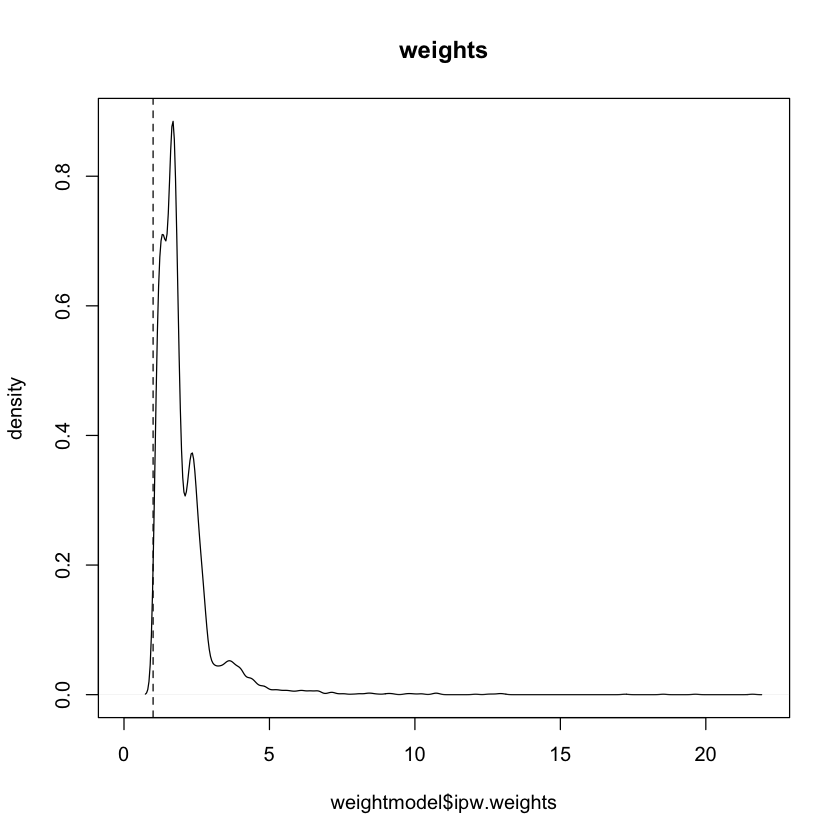

In [58]:
#plot of the weights
ipwplot(weights = weightmodel$ipw.weights, logscal = FALSE, main = 'weights', xlim = c(0,22))

In [59]:
# fit a marginal structural model (risk difference)
mydata$wt2= weightmodel$ipw.weights
msm <- (svyglm(died ~ treatment, design = svydesign( ~1, weights = ~wt2, data = mydata)))

In [60]:
coef(msm)

(Intercept)   treatment 
 0.63046375  0.05154951

In [61]:
confint(msm)

,2.5 %,97.5 %
(Intercept),0.61401445,0.64691305
treatment,0.02333029,0.07976873


In [62]:
# Truncated weights
truncweight <- replace(weight, weight >10, 10)

#get causal risk difference
glm.obj<- glm(died ~ treatment, weights= truncweight, family=  binomial(link= 'identity'))



Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


In [63]:
# other way to do it:

weightmodel <- ipwpoint(exposure = treatment, family = 'binomial', link = 'logit', denominator = ~age + female + meanbp1
                       + ARF +CHF + Cirr+ colcan + Coma + lungcan + MOSF + sepsis , data= mydata, trunc = 0.01) # truncates at 1st and 99th percentile


In [64]:
summary(weightmodel$weights.trunc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.081   1.405   1.721   1.972   2.280   6.379 

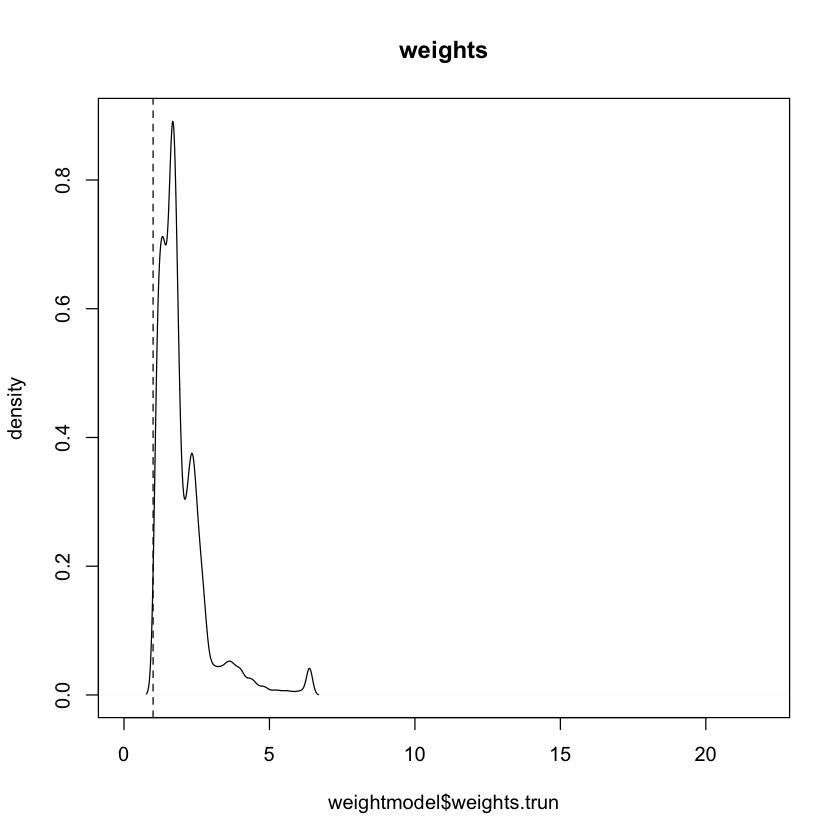

In [65]:
ipwplot(weights = weightmodel$weights.trun, logscale = FALSE, main = 'weights', xlim = c(0,22))

In [66]:
mydata$wt <- weightmodel$weights.trun
msm<- (svyglm(died ~ treatment, design = svydesign( ~1, weights = ~wt, data = mydata)))

In [67]:
coef(msm)

(Intercept)   treatment 
 0.63045533  0.05494865

In [68]:
confint(msm)

,2.5 %,97.5 %
(Intercept),0.61400659,0.64690406
treatment,0.02822931,0.08166799


In [41]:
# it did not make a large difference